# desilike

## Framework to specify DESI (clustering) likelihoods

### Tutorial #1: likelihoods, emulators, samplers, profilers, Fisher

# Goals
At the end of the tutorial you will know:
- how to write clustering likelihoods
- how to emulate their theory
- how to run inference (sampling, profiling, Fisher)


# Environment

To run the following desilike-only examples, you just need to have installed **desilike** (which requires **cosmoprimo**) with:
```
python -m pip install git+https://github.com/cosmodesi/desilike#egg=desilike
```
For the analytic solver:
```
python -m pip install jax[cpu]
```
Easiest is however to use the cosmodesi environment at NERSC:
```
source /global/common/software/desi/users/adematti/cosmodesi_environment.sh main  # source the environment
${COSMODESIMODULES}/install_jupyter_kernel.sh main  # this to be done once
```
NB: to remove the previous kernel:
```
rm -rf $HOME/.local/share/jupyter/kernels/cosmodesi-main
```

To see these slides in a browser, e.g.:
```
firefox desilike_intro.slides.html
```

# Material

This tutorial in https://github.com/cosmodesi/desilike-tutorials.

[desilike docs](https://desilike.readthedocs.io/), especially [getting started](https://desilike.readthedocs.io/en/latest/user/getting_started.html)

[desilike notebooks](https://github.com/cosmodesi/desilike/tree/main/nb)

[application to mock challenge](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_challenge_y1)

[application to mock Y1 cosmological inference](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_y1)

[application to DESI Y5/Y1 forecasts](https://github.com/cosmodesi/desilike/tree/main/nb) (Uendert Andrade)

[application to blinding validation](https://github.com/cosmodesi/desi-y1-kp45/tree/main/blinding) (Uendert Andrade & Edmond Chaussidon for fnl)
 
[application to tests of fiber collisions](https://github.com/mathildepinon/desi_fiber_collisions) (Mathilde Pinon)

# Acknowledgments

[Contributions (direct or indirect) from many people](https://github.com/cosmodesi/desilike/tree/main#acknowledgments)

# Clustering likelihood

Let's describe how to specify the likelihood for power spectrum or correlation function multipoles:
- template
- theory
- observable

## Template

How the linear power spectrum as input of the theory codes is parameterized. Several options are possible, among them:

### Standard (as in BOSS/eBOSS) parameterization
in terms of:
- scaling parameters $q_{\parallel}$, $q_{\perp}$
- variation in the growth rate of structure $df = f / f^{\mathrm{fid}}$

In [29]:
import warnings
warnings.filterwarnings('ignore')
import jax; jax.config.update('jax_platform_name', 'cpu')

In [30]:
from desilike.theories.galaxy_clustering import\
StandardPowerSpectrumTemplate

template = StandardPowerSpectrumTemplate(z=1.1)
# This shows all parameters, after initialization
print(template.all_params)

ParameterCollection(['qpar', 'qper', 'df'])


If you want $q_{\parallel}$, $q_{\perp}$ in terms of isotropic $q_{\mathrm{iso}}$ and AP scaling $q_{\mathrm{ap}}$

In [3]:
template = StandardPowerSpectrumTemplate(z=1.1, apmode='qisoqap')
print(template.all_params)

ParameterCollection(['qiso', 'qap', 'df'])


### [ShapeFit](https://arxiv.org/abs/2106.07641) parameterization
in terms of:
- scaling parameters $q_{\parallel}$, $q_{\perp}$
- variation in the growth rate of structure $df = f / f^{\mathrm{fid}}$
- ShapeFit tilt parameter $dm$

In [4]:
from desilike.theories.galaxy_clustering import\
ShapeFitPowerSpectrumTemplate

template = ShapeFitPowerSpectrumTemplate(z=1.1)
# This shows all parameters, after initialization
print(template.all_params)

ParameterCollection(['qpar', 'qper', 'dm', 'dn', 'df', 'f_sqrt_Ap', 'm', 'n'])


In [5]:
import numpy as np
from matplotlib import colors, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt

from desilike.theories.galaxy_clustering import  KaiserTracerPowerSpectrumMultipoles, ShapeFitPowerSpectrumTemplate, WiggleSplitPowerSpectrumTemplate, BandVelocityPowerSpectrumTemplate

z, b1 = 1.1, 2.

def get_theory(template):
    template.init.update({'z': z, 'fiducial': 'DESI'})
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    theory.params['b1'].update(fixed=False, value=b1)
    theory.params['sn0'].update(fixed=False, value=0.)
    return theory

n = 5
cmap = plt.get_cmap('jet', n)

def plot(template, template_name, params):
    theory_compression = get_theory(template=template)
    theory_compression()
    center_params = theory_compression.runtime_info.pipeline.param_values
    fig, lax = plt.subplots(1, len(params), sharex=False, sharey=True, figsize=(4 * len(params), 4))
    lax = lax.flatten()
    fig.subplots_adjust(wspace=0.25)
    
    for iax, (param, values) in enumerate(params.items()):
        theory_compression(**center_params)
        ax = lax[iax]
        for ivalue, value in enumerate(values):
            poles = theory_compression(**{param: value})
            for ill, ell in enumerate(theory_compression.ells):
                ax.plot(theory_compression.k, theory_compression.k * poles[ill], color=cmap(ivalue))
        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        ax.grid(True)
        norm = colors.Normalize(vmin=values[0], vmax=values[-1])
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        divider = make_axes_locatable(ax)
        cax = divider.new_vertical(size='5%', pad = 0.5)
        fig.add_axes(cax)
        cbar = plt.colorbar(sm, cax=cax, ax=ax, orientation='horizontal')
        cbar.set_label(theory_compression.all_params[param].latex(inline=True), rotation=0)
    plt.show()

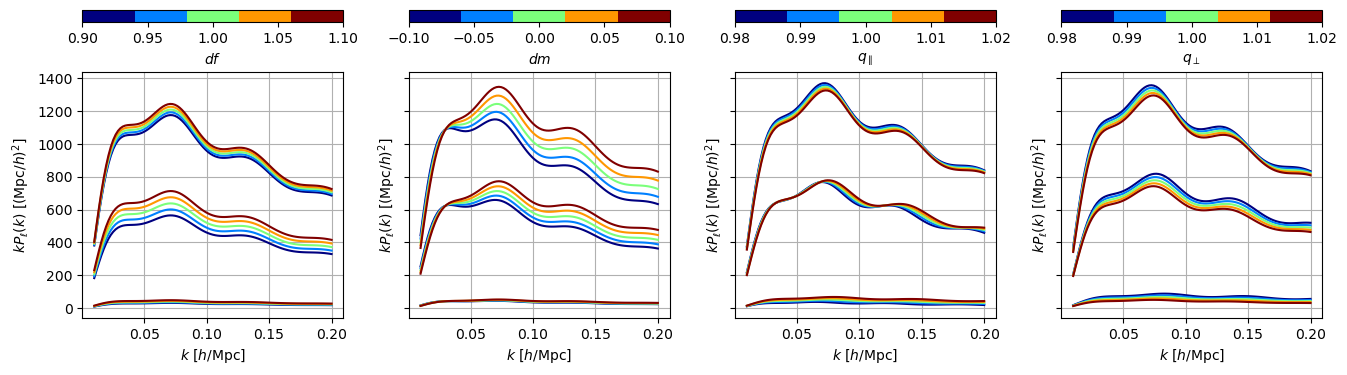

In [6]:
plot(ShapeFitPowerSpectrumTemplate(), 'shapefit',\
{'df': np.linspace(0.9, 1.1, n), 'dm': np.linspace(-0.1, 0.1, n), 'qpar': np.linspace(0.98, 1.02, n), 'qper': np.linspace(0.98, 1.02, n)})

### Direct parameterization

In terms of base cosmological parameters

In [7]:
from desilike.theories.galaxy_clustering import\
DirectPowerSpectrumTemplate

template = DirectPowerSpectrumTemplate(z=1.1)
# This shows all parameters, after initialization of the calculator
print(template.all_params)

ParameterCollection(['h', 'Omega_m', 'omega_b', 'logA', 'n_s', 'tau_reio', 'm_ncdm', 'N_ur', 'w0_fld', 'wa_fld', 'Omega_k'])


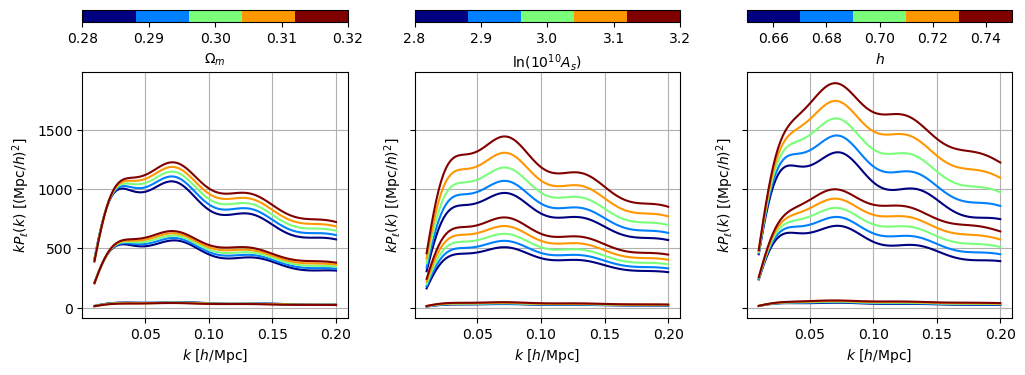

In [8]:
plot(DirectPowerSpectrumTemplate(),
'direct', {'Omega_m': np.linspace(0.28, 0.32, n), 'logA': np.linspace(2.8, 3.2, n), 'h': np.linspace(0.65, 0.75, n)})

In [9]:
from desilike.theories import Cosmoprimo

cosmo = Cosmoprimo(fiducial='DESI')
# Default parameters are specified in .yaml file, but can be updated:
print(cosmo.init.params)
# Changes to cosmo.init.params impact any calculator (pipeline) that depends on cosmo
# Changes to cosmo.all_params impact this calculator (pipeline) only

del cosmo.init.params['omega_cdm']
cosmo.init.params['Omega_m'] = { 
        'prior': {'limits': [0.01, 0.99]},
        'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
        'latex': r'\Omega_{m}',
        'delta': 0.005}
for name in ['n_s', 'tau_reio']:
    cosmo.init.params[name].update(fixed=True)
template = DirectPowerSpectrumTemplate(cosmo=cosmo, z=1.1)
print(template.all_params['Omega_m'].ref.loc)

ParameterCollection(['h', 'theta_MC_100', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio', 'm_ncdm', 'N_ur', 'w0_fld', 'wa_fld', 'Omega_k'])
0.3


See `desilike.theories.galaxy_clustering.power_template` for all templates.

## Interlude: look for help!

In [10]:
help(ShapeFitPowerSpectrumTemplate)

Help on class ShapeFitPowerSpectrumTemplate in module desilike.theories.galaxy_clustering.power_template:

class ShapeFitPowerSpectrumTemplate(BasePowerSpectrumTemplate, ShapeFitPowerSpectrumExtractor)
 |  ShapeFitPowerSpectrumTemplate(*args, **kwargs)
 |  
 |  ShapeFit power spectrum template.
 |  
 |  Parameters
 |  ----------
 |  k : array, default=None
 |      Theory wavenumbers where to evaluate linear power spectrum.
 |  
 |  z : float, default=1.
 |      Effective redshift.
 |  
 |  kp : float, default=0.03
 |      Pivot point in ShapeFit parameterization.
 |  
 |  a : float, default=0.6
 |      :math:`a` parameter in ShapeFit parameterization.
 |  
 |  apmode : str, default='qparqper'
 |      Alcock-Paczynski parameterization:
 |  
 |      - 'qiso': single istropic parameter 'qiso'
 |      - 'qap': single, Alcock-Paczynski parameter 'qap'
 |      - 'qisoqap': two parameters 'qiso', 'qap'
 |      - 'qparqper': two parameters 'qpar' (scaling along the line-of-sight), 'qper' (scal

## Theory

Currently available:

- Simple Kaiser model: KaiserTracerPowerSpectrumMultipoles

- Velocileptors: LPTVelocileptorsTracerPowerSpectrumMultipoles (plus other flavors)

- PyBird: PyBirdTracerPowerSpectrumMultipoles

- TNS 1 loop: TNSTracerPowerSpectrumMultipoles

- empirical BAO: DampedBAOWigglesPowerSpectrumMultipoles

- PNG (scale-dependent bias): PNGTracerPowerSpectrumMultipoles

- yours!

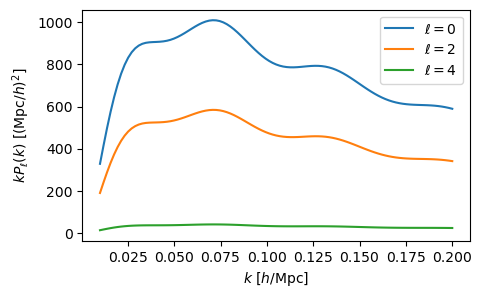

In [11]:
from desilike.theories.galaxy_clustering import KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles, PyBirdTracerPowerSpectrumMultipoles

# Or LPTVelocileptorsTracerPowerSpectrumMultipoles, PyBirdTracerPowerSpectrumMultipoles, etc.
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
# This is how any calculator (template, theory, etc.) can be called
power = theory(b1=1.8)
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(5, 3), squeeze=True)
for ill, ell in enumerate(theory.ells):
    ax.plot(theory.k, theory.k * theory.power[ill], label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]');

For correlation function, change "PowerSpectrumMultipoles" for "CorrelationFunctionMultipoles".

ParameterCollection(['h', 'omega_b', 'logA', 'Omega_m', 'b1', 'b3', 'b2', 'b4', 'cct', 'cr1', 'cr2'])


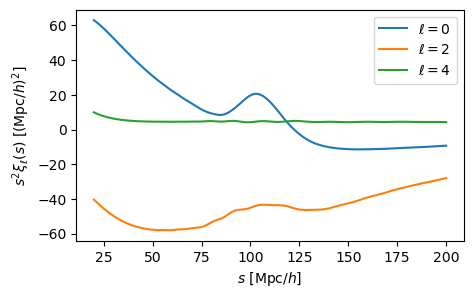

In [12]:
from desilike.theories.galaxy_clustering import KaiserTracerCorrelationFunctionMultipoles, LPTVelocileptorsTracerCorrelationFunctionMultipoles, PyBirdTracerCorrelationFunctionMultipoles

# Or KaiserTracerCorrelationFunctionMultipoles LPTVelocileptorsTracerCorrelationFunctionMultipoles, etc.
theory = PyBirdTracerCorrelationFunctionMultipoles(template=template)
# This is how to get all varied parameters
print(theory.varied_params)
corr = theory(b1=1.8, h=0.69)
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(5, 3), squeeze=True)
for ill, ell in enumerate(theory.ells):
    ax.plot(theory.s, theory.s**2 * corr[ill], label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$s^{2} \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]');

## Interlude: install any calculator! (and sampler and profiler)

In [13]:
from desilike import setup_logging

setup_logging()  # set logging

from desilike import Installer

theory = LPTVelocileptorsTracerCorrelationFunctionMultipoles(template=template)
installer = Installer(user=True)
installer(theory)

[000000.09] [0/1] 05-24 20:00  Installer                 INFO     Installation directory is /home/adematti/.local.
[000000.18] [0/1] 05-24 20:00  Install                   INFO     Requirement already satisfied: velocileptors in /home/adematti/.local/lib/python3.9/site-packages
[000000.18] [0/1] 05-24 20:00  BaseConfig                INFO     Saving /home/adematti/.desilike/config.yaml.


## Observable

Then, we want to compare the theory to data (an *observable*), typically:

- power spectrum multipoles, with `TracerPowerSpectrumMultipolesObservable`
- correlation function multipoles, with `TracerCorrelationFunctionMultipolesObservable`

In [14]:
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, TracerCorrelationFunctionMultipolesObservable

template = ShapeFitPowerSpectrumTemplate(z=1.1)
b1 = 1.5
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
observable = TracerPowerSpectrumMultipolesObservable(\
             data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
             covariance=None,  # path to mocks, array (covariance matrix), or None
             klim={0: [0.01, 0.2, 0.005], 2: [0.01, 0.2, 0.005]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
             theory=theory)  # previously defined theory

Note: we do not have a covariance matrix yet, let's compute it (Gaussian and no window approximation)

In [15]:
from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix

footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
cov = covariance(b1=b1)   # evaluate covariance matrix at this parameter

## Likelihood

In [16]:
from desilike.likelihoods import ObservablesGaussianLikelihood

# No need to specify covariance if already given to the observable (TracerPowerSpectrumMultipolesObservable)
# If mocks are given to each observable, the likelihood covariance matrix is computed on-the-fly,
# using mocks from each observable (taking into account correlations)
likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
print(likelihood(b1=b1))  # actually logposterior = likelihood.loglikelihood + likelihood.logprior

0.0


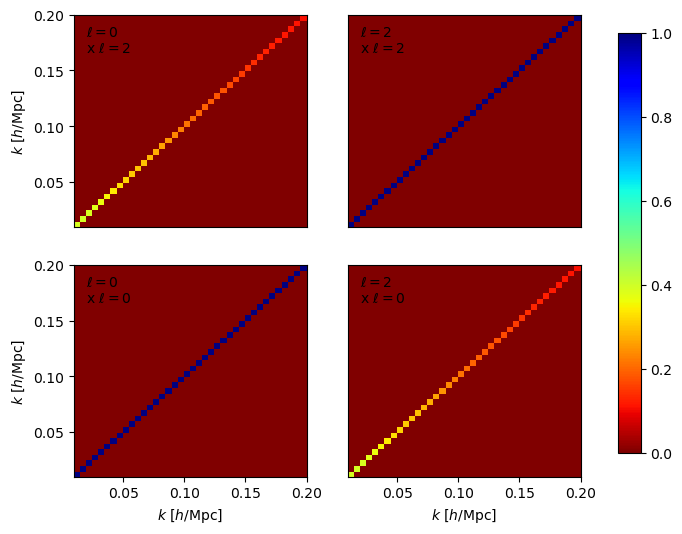

In [17]:
observable.plot_covariance_matrix();

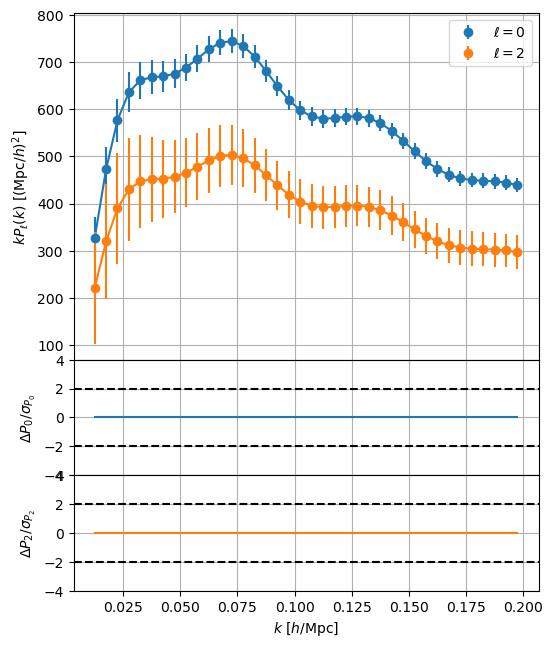

In [18]:
observable.plot();

The likelihood (and any other calculator) can be called at any point with

In [19]:
likelihood(b1=1., sn0=1000.)  # update linear bias b1, and shot noise sn0
likelihood(qpar=0.99)  # update scaling parameter qpar; b1 and sn0 are kept to 1. and 1000.
likelihood(sn0=100.)  # update shot noise, the template is to re-calculated

theory.power  # contains multipoles of the power spectrum, evaluated at b1=1., qpar=0.99 and sn0=100.
theory(sn0=1000.);  # recomputes the theory at sn0=1000.

The likelihood (or any calculator) can be reparameterized following e.g.

In [20]:
likelihood.all_params['qpar'].update(derived='{qiso} * {qap}**(2. / 3.)')
likelihood.all_params['qper'].update(derived='{qiso} * {qap}**(- 1. / 3.)')
# Then add qiso, qap to the parameter collection
likelihood.all_params['qiso'] = {'prior': {'limits': [0.9, 1.1]}, 'latex': 'q_{\mathrm{iso}}'}
likelihood.all_params['qap'] = {'prior': {'limits': [0.9, 1.1]}, 'latex': 'q_{\mathrm{ap}}'}
# Now the likelihood has for varied parameters
likelihood.varied_params  # b1, sn0, df, dm, qiso, qap

ParameterCollection(['dm', 'df', 'b1', 'sn0', 'qiso', 'qap'])

One can update any calculator with `calculator.init.update`

In [21]:
template = DirectPowerSpectrumTemplate(z=1.1)
theory.init.update(template=template)  # this impacts any calculator that depends on theory
likelihood.varied_params

ParameterCollection(['h', 'Omega_m', 'omega_b', 'logA', 'b1', 'sn0'])

## Combining observables

In [22]:
theory_xi = KaiserTracerCorrelationFunctionMultipoles(template=template)
observable_xi = TracerCorrelationFunctionMultipolesObservable(\
                data={'b1': b1},
                covariance=None,
                slim={0: [20., 150., 5.], 2: [20., 150., 5.]},
                theory=theory_xi)

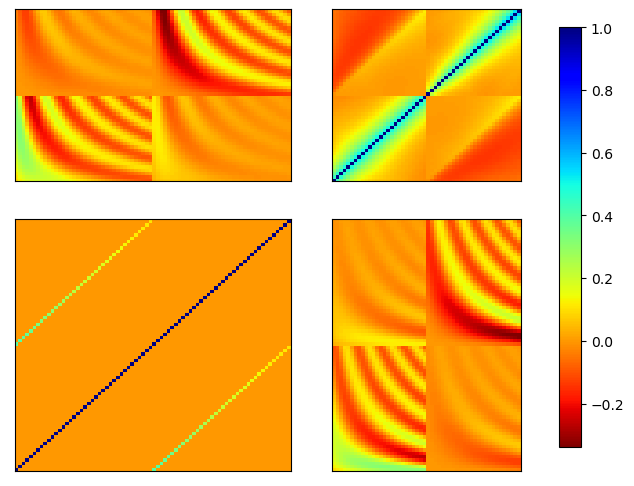

In [23]:
covariance_pk_xi = ObservablesCovarianceMatrix(\
                   observables=[observable, observable_xi],
                   footprints=footprint)
likelihood = ObservablesGaussianLikelihood(\
                    observables=[observable, observable_xi],
                    covariance=covariance_pk_xi(b1=b1))
likelihood()
likelihood.plot_covariance_matrix();

## Summing likelihoods

In [24]:
theory2 = theory.deepcopy()
for name in ['b1', 'sn0']:
    theory2.init.params[name].update(namespace='tracer2')
observable2 = TracerPowerSpectrumMultipolesObservable(\
             data={'tracer2.b1': 2.},
             covariance=covariance(b1=2),
             klim={0: [0.01, 0.2, 0.005], 2: [0.01, 0.2, 0.005]},
             theory=theory2)
likelihood2 = ObservablesGaussianLikelihood(observables=observable2)
like = likelihood + likelihood2
like.varied_params

ParameterCollection(['h', 'Omega_m', 'omega_b', 'logA', 'tracer2.b1', 'tracer2.sn0', 'b1', 'sn0'])

The likelihood can be analytically marginalized over linear parameters (here `sn0`, `tracer2.sn0`)

In [25]:
# '.best': set sn0 at best fit
# '.marg': marginalization, assuming Gaussian likelihood
# '.auto': automatically choose between '.best' (likelihood profiling) and '.marg' (likelihood sampling)
for param in like.all_params.select(name='*sn0'):
    param.update(derived='.auto')
# Now the likelihood has for varied parameters (no sn0)
like.varied_params

ParameterCollection(['h', 'Omega_m', 'omega_b', 'logA', 'tracer2.b1', 'b1'])

## Compressed parameters
Interpration of compressed parameters (e.g. $q_{\parallel}$, $q_{\perp}$, $df$, $dm$) into cosmological constraints.

In [26]:
# Placeholder data and covariance: these can be computed with samplers or Fisher tools wrapped into desilike
from desilike.observables.galaxy_clustering import BAOCompressionObservable,\
StandardCompressionObservable, ShapeFitCompressionObservable

observable = ShapeFitCompressionObservable(data=[1., 1., 0., 1.],
                                           covariance=np.diag([0.01, 0.01, 0.0001, 0.01]),
                                           quantities=['qpar', 'qper', 'dm', 'df'], z=1.1)
likelihood = ObservablesGaussianLikelihood(observables=[observable])
print(likelihood.varied_params)

[000026.11] [0/1] 05-24 20:00  ShapeFitCompressionObservable INFO     Found quantities ['qpar', 'qper', 'dm', 'df'].
ParameterCollection(['h', 'Omega_m', 'omega_b', 'logA'])


# Bindings

Now we have our likelihood, we can bind it to external cosmological inference codes (Cobaya, CosmoSIS and MontePython).

Let's recap the likelihood definition in a function

In [27]:
def MyLikelihood():

    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, BoxFootprint, ObservablesCovarianceMatrix
    from desilike.likelihoods import ObservablesGaussianLikelihood

    # 'external' means "get primordial quantities from external source, e.g. cobaya
    template = DirectPowerSpectrumTemplate(z=1.1, cosmo='external')
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    observable = TracerPowerSpectrumMultipolesObservable(data={'b1': 1.2}, covariance=None,
                                                         klim={0: [0.01, 0.2, 0.005], 2: [0.01, 0.2, 0.005]}, theory=theory)
    footprint = BoxFootprint(volume=1e9, nbar=1e-3)
    covariance = ObservablesCovarianceMatrix(observables=observable, footprints=footprint)
    cov = covariance(b1=1.2)
    return ObservablesGaussianLikelihood(observables=observable, covariance=cov)

Let's pass this function to the generators that will write the necessary files
to import it as an external likelihood in Cobaya, CosmoSIS and MontePython.

You can pass `name_like` to give the likelihood another name than `MyLikelihood`
and `kw_like` to pass optional arguments to `MyLikelihood`.

In [ ]:
from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator

CobayaLikelihoodGenerator()(MyLikelihood)
CosmoSISLikelihoodGenerator()(MyLikelihood)
MontePythonLikelihoodGenerator()(MyLikelihood)

We will explore these bindings into more details in the second tutorial.

# Emulators

EFT theory models typically take ~ 1 second to run. We provide tools for emulation:

- Taylor expansion, up to a given order, with `TaylorEmulatorEngine`
- Neural net (multilayer perceptron), with `MLPEmulatorEngine`

In [31]:
template = DirectPowerSpectrumTemplate(z=1.1)
template.init.params['omega_b'].update(fixed=True)
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
observable = TracerPowerSpectrumMultipolesObservable(data={'b1': 1.8}, covariance=None,
                                                     klim={0: [0.01, 0.2, 0.005], 2: [0.01, 0.2, 0.005]}, theory=theory)
footprint = BoxFootprint(volume=1e9, nbar=1e-3)
covariance = ObservablesCovarianceMatrix(observables=observable, footprints=footprint)
likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=covariance(b1=1.8))

Let's emulate the perturbation theory part (.pt)
by performing a Taylor expansion of order 2 (except for sn0)
Theory derivatives are evaluated with jax auto-differentiation if possible,
else finite differentiation.

In [32]:
from desilike.emulators import Emulator, TaylorEmulatorEngine, EmulatedCalculator

emulator = Emulator(theory.pt,
                    engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))
emulator.set_samples()
emulator.fit()  # set Taylor expansion

# Emulator can be saved with:
emulator.save('_tests/emulator.npy')
# And reloaded with:
pt = EmulatedCalculator.load('_tests/emulator.npy')

theory.init.update(pt=pt)
# Now the theory will run much faster!
theory(logA=3.);

[024877.80] [0/1] 05-25 02:54  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[024877.80] [0/1] 05-25 02:54  Emulator                  INFO     Found varying ['pk_dd', 'pk_dt', 'pk_tt', 'pk11'] and fixed ['k', 'z', 'ells', 'names'] outputs.
[024878.15] [0/1] 05-25 02:54  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[024879.96] [0/1] 05-25 02:54  Differentiation           INFO     Using finite-differentiation for parameter h.
[024880.29] [0/1] 05-25 02:54  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[024880.63] [0/1] 05-25 02:54  Differentiation           INFO     Using finite-differentiation for parameter logA.
[024880.63] [0/1] 05-25 02:54  Differentiation           INFO     h grid is [0.6706 0.6736 0.6766].
[024880.63] [0/1] 05-25 02:54  Differentiation           INFO     Omega_m grid is [0.31019172 0.31519172 0.32019172].
[024880.63] [0/1] 05-25 02:54  Differentiation      

# Profilers, samplers

Because we may want to test cosmological inference in-place
(without resorting to montepython, cosmosis or cobaya),
we provide wrapping for some profilers and samplers.

Profilers currently available are:
- [minuit](https://github.com/scikit-hep/iminuit), used by the high-energy physics community, with `MinuitProfiler`
- [bobyqa](https://github.com/numericalalgorithmsgroup/pybobyqa), with `BOBYQAProfiler`
- [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize>), with `ScipyProfiler`

These can be used with e.g.

In [33]:
from desilike.profilers import MinuitProfiler

profiler = MinuitProfiler(likelihood)
profiles = profiler.maximize(niterations=5)
profiles = profiler.interval(params=['h', 'Omega_m', 'logA'])
# To assess best fit parameters (among all iterations)
profiles.bestfit.choice()
# To print relevant information
print(profiles.to_stats(tablefmt='pretty'))

[024887.50] [0/1] 05-25 02:54  MinuitProfiler            INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
+------------------------------------+--------+---------+-------+---------------+
| chi2 / (76 - 5) = 0.00 / 71 = 0.00 | varied | bestfit | error |   interval    |
+------------------------------------+--------+---------+-------+---------------+
|                 h                  |  True  |  0.674  | 0.015 | -0.015/+0.015 |
|              Omega_m               |  True  |  0.315  | 0.015 | -0.015/+0.016 |
|                logA                |  True  |  3.036  | 0.086 | -0.087/+0.086 |
|                 b1                 |  True  |  1.800  | 0.057 |               |
|                sn0                 |  True  |   0.    |  99   |               |
+------------------------------------+--------+---------+-------+---------------+


```
+------------------------------------+--------+---------+-------+---------------+
| chi2 / (76 - 5) = 0.00 / 71 = 0.00 | varied | bestfit | error |   interval    |
+------------------------------------+--------+---------+-------+---------------+
|                 h                  |  True  |  0.674  | 0.015 | -0.015/+0.015 |
|              Omega_m               |  True  |  0.315  | 0.015 | -0.015/+0.016 |
|                logA                |  True  |  3.036  | 0.086 | -0.087/+0.086 |
|                 b1                 |  True  |  1.800  | 0.057 |               |
|                sn0                 |  True  |   0.    |  99   |               |
+------------------------------------+--------+---------+-------+---------------+
```

## Reminder: installer

In [34]:
installer = Installer(user=True)
installer(MinuitProfiler)

[024907.66] [0/1] 05-25 02:55  Installer                 INFO     Installation directory is /home/adematti/.local.
[024907.67] [0/1] 05-25 02:55  Install                   INFO     Requirement already satisfied: iminuit in /home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages
[024907.67] [0/1] 05-25 02:55  BaseConfig                INFO     Saving /home/adematti/.desilike/config.yaml.


Samplers currently available are:
- [Antony Lewis MCMC Sampler](https://github.com/CobayaSampler/cobaya/tree/master/cobaya/samplers/mcmc>) with `MCMCSampler`
- [emcee ensemble sampler](https://github.com/dfm/emcee), with `EmceeSampler`
- [zeus ensemble slicing sampler](https://github.com/minaskar/zeus), with `ZeusSampler`
- [pocomc pre-conditioned Monte-Carlo sampler](https://github.com/minaskar/pocomc), with `PocoMCSampler`
- [dynesty nested sampler](https://github.com/joshspeagle/dynesty), with `DynamicDynestySampler`
- [polychord nested sampler](https://github.com/PolyChord/PolyChordLite), with `NestedSampler`

These can be used with e.g.

In [36]:
from desilike.samplers import EmceeSampler
from desilike.samples import Chain

sampler = EmceeSampler(likelihood, seed=42, chains=1)
chains = sampler.run(check={'max_eigen_gr': 0.05})  # run until Gelman-Rubin criterion < 0.05
chain = Chain.concatenate([chain.remove_burnin(0.5) for chain in chains])[::10]  # thinning

[025475.04] [0/1] 05-25 03:04  EmceeSampler              INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
[025501.98] [0/1] 05-25 03:05  EmceeSampler              INFO     Diagnostics:
[025501.99] [0/1] 05-25 03:05  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.576; not < 0.05.
[025502.01] [0/1] 05-25 03:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.049.
[025502.39] [0/1] 05-25 03:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.219.
[025502.40] [0/1] 05-25 03:05  EmceeSampler              INFO     - max Geweke is 0.372.
[025502.40] [0/1] 05-25 03:05  EmceeSampler              INFO     - Geweke p-value is 0.468.
[025502.42] [0/1] 05-25 03:05  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 9.51.
[025528.99] [0/1] 05-25 03:05  EmceeSampler              INFO     Diagnostics:
[025529.01] [0/1] 05-25 03:05  EmceeSampler              INFO     - m

[038349.77] [0/1] 05-25 06:39  EmceeSampler              INFO     - Geweke p-value is 6.46e-05.
[038349.80] [0/1] 05-25 06:39  EmceeSampler              INFO     - (1500 iterations / integrated autocorrelation time) is 27.2.
[038349.80] [0/1] 05-25 06:39  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.125.
[038399.43] [0/1] 05-25 06:39  EmceeSampler              INFO     Diagnostics:
[038399.45] [0/1] 05-25 06:39  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.499; not < 0.05.
[038399.47] [0/1] 05-25 06:39  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0259.
[038399.57] [0/1] 05-25 06:39  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0837.
[038399.59] [0/1] 05-25 06:39  EmceeSampler              INFO     - max Geweke is 0.422.
[038399.59] [0/1] 05-25 06:39  EmceeSampler              INFO     - Geweke p-value is 0.466.
[038399.62] [0/1] 05-25 06:39  EmceeSampler   

[038861.81] [0/1] 05-25 06:47  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.00496.
[038861.95] [0/1] 05-25 06:47  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0658.
[038861.97] [0/1] 05-25 06:47  EmceeSampler              INFO     - max Geweke is 0.48.
[038861.97] [0/1] 05-25 06:47  EmceeSampler              INFO     - Geweke p-value is 0.431.
[038862.02] [0/1] 05-25 06:47  EmceeSampler              INFO     - (3000 iterations / integrated autocorrelation time) is 33.4.
[038862.02] [0/1] 05-25 06:47  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.186.
[038913.22] [0/1] 05-25 06:48  EmceeSampler              INFO     Diagnostics:
[038913.25] [0/1] 05-25 06:48  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.131; not < 0.05.
[038913.27] [0/1] 05-25 06:48  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0148.
[038913.42] [0/1] 05-25 06:48  EmceeS

[039324.17] [0/1] 05-25 06:55  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0597.
[039375.13] [0/1] 05-25 06:56  EmceeSampler              INFO     Diagnostics:
[039375.16] [0/1] 05-25 06:56  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.184; not < 0.05.
[039375.19] [0/1] 05-25 06:56  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0148.
[039375.36] [0/1] 05-25 06:56  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0778.
[039375.37] [0/1] 05-25 06:56  EmceeSampler              INFO     - max Geweke is 0.257.
[039375.37] [0/1] 05-25 06:56  EmceeSampler              INFO     - Geweke p-value is 0.761.
[039375.45] [0/1] 05-25 06:56  EmceeSampler              INFO     - (4500 iterations / integrated autocorrelation time) (reliable) is 50.
[039375.45] [0/1] 05-25 06:56  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.116.
[0394

[039828.83] [0/1] 05-25 07:03  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0249.
[039828.85] [0/1] 05-25 07:03  EmceeSampler              INFO     - max Geweke is 0.425.
[039828.85] [0/1] 05-25 07:03  EmceeSampler              INFO     - Geweke p-value is 0.395.
[039828.94] [0/1] 05-25 07:03  EmceeSampler              INFO     - (5850 iterations / integrated autocorrelation time) (reliable) is 67.3.
[039828.95] [0/1] 05-25 07:03  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0291.
[039875.92] [0/1] 05-25 07:04  EmceeSampler              INFO     Diagnostics:
[039875.94] [0/1] 05-25 07:04  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.183; not < 0.05.
[039875.98] [0/1] 05-25 07:04  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0108.
[039876.17] [0/1] 05-25 07:04  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0302.
[039876.18]

In [37]:
# To print relevant information
print(chain.to_stats(tablefmt='pretty'))

+---------+--------+-------+--------+-------+-----------------+-----------------+
|         | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+---------+--------+-------+--------+-------+-----------------+-----------------+
|    h    | 0.675  | 0.674 | 0.674  | 0.015 |  -0.015/+0.015  |  -0.016/+0.014  |
| Omega_m | 0.314  | 0.316 | 0.316  | 0.015 |  -0.016/+0.015  |  -0.016/+0.015  |
|  logA   | 3.025  | 3.030 | 3.031  | 0.085 |  -0.084/+0.084  |  -0.087/+0.081  |
|   b1    | 1.812  | 1.804 | 1.804  | 0.056 |  -0.056/+0.055  |  -0.057/+0.054  |
|   sn0   |  -14   |  -9   |   -6   |  98   |    -100./+97    |     -98/+99     |
+---------+--------+-------+--------+-------+-----------------+-----------------+


[040167.70] [0/1] 05-25 07:09  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


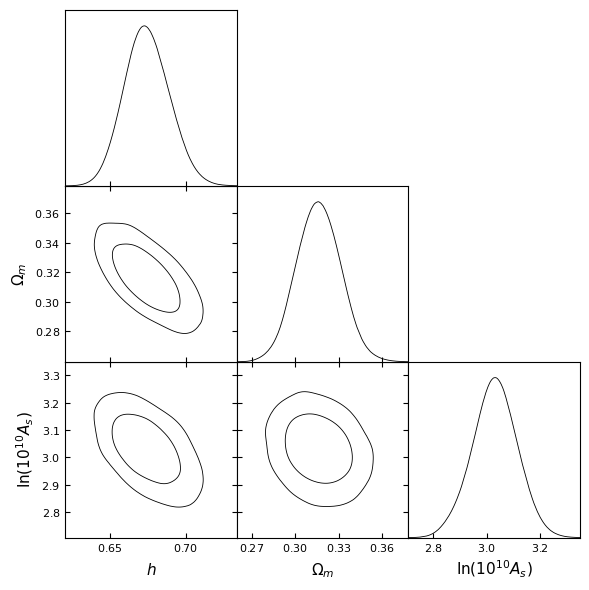

In [38]:
from desilike.samples import plotting
plotting.plot_triangle(chain, params=['h', 'Omega_m', 'logA'])

# Fisher

We provide a routine for Fisher estimation

In [39]:
from desilike import Fisher

fisher = Fisher(likelihood)
# Estimate Fisher (precision) matrix at b1=2, using jax auto-differentiation where possible,
# else finite differentiation (with step :attr:`Parameter.delta`)
fish = fisher(b1=2.)

[040169.65] [0/1] 05-25 07:09  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
[040169.67] [0/1] 05-25 07:09  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'logA', 'b1', 'sn0'].
[040170.32] [0/1] 05-25 07:09  Differentiation           INFO     Using auto-differentiation for parameter h.
[040170.37] [0/1] 05-25 07:09  Differentiation           INFO     Using auto-differentiation for parameter Omega_m.
[040170.41] [0/1] 05-25 07:09  Differentiation           INFO     Using auto-differentiation for parameter logA.
[040170.53] [0/1] 05-25 07:09  Differentiation           INFO     Using auto-differentiation for parameter b1.
[040170.67] [0/1] 05-25 07:09  Differentiation           INFO     Using auto-differentiation for parameter sn0.


In [ ]:
# LikelihoodFisher can be saved with:
fish.save('_tests/fisher.npy')
# And reloaded with:
from desilike import LikelihoodFisher
fish = LikelihoodFisher.load('_tests/fisher.npy')

In [40]:
# To sum independent likelihood's Fisher matrices:
# fish1 + fish2
# To get covariance matrix
covariance = fish.covariance()
# To print relevant information
print(fish.to_stats(params=['h', 'Omega_m', 'logA'], tablefmt='pretty'))
# To get a new likelihood
like = fish.to_likelihood()
like(b1=2.1);

+-----+-----------+
| FoM | 217981.93 |
+-----+-----------+
+------+-------+---------+-------+
|      |   h   | Omega_m | logA  |
+------+-------+---------+-------+
| mean | 0.674 |  0.315  | 3.029 |
| std  | 0.012 |  0.013  | 0.074 |
+------+-------+---------+-------+
+---------+---------+---------+---------+
|         |    h    | Omega_m |  logA   |
+---------+---------+---------+---------+
|    h    | 1.6e-4  | -9.9e-5 | -4.9e-4 |
| Omega_m | -9.9e-5 | 1.6e-4  | -1.8e-4 |
|  logA   | -4.9e-4 | -1.8e-4 | 0.0054  |
+---------+---------+---------+---------+


# Interlude: MPI

- profilers (iterations, starting from different points, in parallel)
- samplers (chains and parallelization for ensemble samplers)
- emulators (theory evaluation in parallel)
- fisher (derivatives in parallel)
all take advantage of MPI. You just need to run your script with:

```mpiexec -np 64 python yourscript.py```

At NERSC:

```srun -n 64 python yourscript.py```

If you are not bored yet, we can take a look at actually useful examples
(sorry, I was not brave enough to wrap them here for today...).

[application to mock challenge](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_challenge_y1)

[application to mock Y1 cosmological inference](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_y1): compressed and direct forecasts

# Wrap-up

desilike is a framework that makes it (hopefully) easy to define clustering likelihoods, and wraps many useful utilities for inference: emulators, profilers, samplers, Fisher estimation.

[desilike docs](https://desilike.readthedocs.io/), especially [getting started](https://desilike.readthedocs.io/en/latest/user/getting_started.html)

[desilike notebooks](https://github.com/cosmodesi/desilike/tree/main/nb)

Environment at NERSC with desilike, Cobaya, CosmoSIS, Class, camb, and many samplers installed:
```
source /global/cfs/cdirs/desi/users/adematti/cosmodesi_environment.sh main  # source the environment
# You may want to have it in the jupyter-kernel for plots
${COSMODESIMODULES}/install_jupyter_kernel.sh main  # this to be done once
```